# Statistics and Figures for Analysis by LFMC Range

## Initialisation

In [1]:
import json
import numpy as np
import os
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from matplotlib.legend import Legend

import initialise
import common
from analysis_utils import calc_statistics
from display_utils import display_frames

In [2]:
MIN_LFMC = 50
FIRE_RISK_THRESHOLD = 120
BIN_SIZE = 5

MODEL_RMSE = 27.52
MODEL_R2 = 0.47

TICK_SIZE = 7
LEGEND_SIZE = 7
FONT_SIZE = 7
TITLE_SIZE = 8
MARKER_SIZE = 5

## Get the Samples and Predictions

In [3]:
samples_file = os.path.join(common.DATASETS_DIR, 'samples_730days.csv')
model_dir = os.path.join(common.MODELS_DIR, 'evaluation_models', 'test3')

In [4]:
with open(os.path.join(model_dir, 'model_params.json'), 'r') as f:
    params = json.load(f)
samples = pd.read_csv(samples_file, index_col=0)
predict1 = pd.read_csv(os.path.join(model_dir, f'ensemble{common.ENSEMBLE_SIZE}_{common.ANALYSIS_MODEL}.csv'), index_col=0)
samples1 = samples.reindex(predict1.index)
samples1 = samples1[params['targetColumn']]

## Functions

### Statistical Functions

In [5]:
def rmse(errors):
    return np.sqrt((errors ** 2).mean())

In [6]:
def mae(errors):
    return errors.abs().mean()

In [7]:
def iqr_lower(errors):
    return errors.quantile(0.25)

In [8]:
def iqr_upper(errors):
    return errors.quantile(0.75)

In [9]:
def gen_stats(y, yhat, width=1, clip=True, lower=0, upper=300):
    data = pd.DataFrame({'y': y, 'yhat': yhat})
    data['LFMC_group'] = ((data.y / width).round() * width)
    if clip:
        data['LFMC_group'] = data['LFMC_group'].clip(lower, upper)
    data['Pred_error'] = data.yhat - data.y
    stats_ = data.groupby(['LFMC_group']).Pred_error.agg(['mean', 'std', 'count', rmse, mae, iqr_lower, iqr_upper])
    plot_range = range(lower, upper+1, width)
    return stats_.reindex(plot_range)   

In [10]:
def gen_means(y, yhat, width=1, clip=True, lower=0, upper=300):
    stats_ = []
    for _, pred in yhat.iteritems():
        stats_.append(gen_stats(y, pred, width=width, clip=clip, lower=lower, upper=upper))
    return pd.concat(stats_).groupby('LFMC_group').mean() #.convert_dtypes()

In [11]:
def gen_counts(y, width=1, clip=True, lower=0, upper=300):
    data = pd.DataFrame({'count': y, 'LFMC_group': ((y / width).round() * width)})
    if clip:
        data['LFMC_group'] = data['LFMC_group'].clip(lower, upper)
    data = data.groupby(['LFMC_group']).count()
    data = data.reindex(range(lower, upper+1, width))
    return data

### Plotting Functions

In [109]:
def plot_by_range(stats_plot, ax, xrange=[0, 300], xfocus=[0, 300], width=1, yrange=[-100, 100], yfocus=20, clip=True):
    plot_range = range(xrange[0], xrange[1]+1, width)
    ax.plot(stats_plot['mean'], label='Bias', color=sns.color_palette('tab20')[0])
    l1, = ax.plot(stats_plot.loc[:xfocus[0], 'rmse'], color=sns.color_palette('tab20')[3], linestyle='--')
    l2, = ax.plot(stats_plot.loc[xfocus[0]:xfocus[1], 'rmse'], color=sns.color_palette('tab20')[2])
    ax.plot(stats_plot.loc[xfocus[1]:, 'rmse'], color=sns.color_palette('tab20')[3], linestyle='--')
    ax.fill_between(
        plot_range,
        stats_plot['mean'] - stats_plot['std'],  #stats_plot['iqr_lower'],
        stats_plot['mean'] + stats_plot['std'],  #stats_plot['iqr_upper'],
        color=sns.color_palette('tab20')[1],
        alpha=0.5
    )
    ax.plot([xrange[0], xrange[1]], [yfocus, yfocus], ':', color=(0.5, 0.5, 0.5), linewidth=1)
    ax.text(xrange[1]-1, yfocus, f'RMSE={yfocus}%', va='bottom', ha='right', size=FONT_SIZE)
    negative = stats_plot['mean'][stats_plot['mean'].lt(0)]
    ax.plot([negative.index[0], negative.index[0]], [yrange[0], negative.iloc[0]], ':', color=(0.5, 0.5, 0.5), linewidth=1)
    temp_text = f'Models switch from\noverestimating to\nunderestimating at\nLFMC={negative.index[0]}%'
    ax.text(negative.index[0]+2, (yrange[0] - negative.iloc[0]) / 2, temp_text, va='top', ha='left', fontsize=FONT_SIZE)
    handles, labels_ = ax.get_legend_handles_labels()
    ax.legend(handles + [(l1, l2)], labels_ + ['RMSE'], loc='lower left', fontsize=LEGEND_SIZE,
              handlelength=2.0, handler_map={tuple: HandlerTuple(ndivide=None)})
    ax.set_ylabel('Estimation error (%)', fontsize=FONT_SIZE)
#    ax.set_xlabel('Measured LFMC (%)', fontsize=FONT_SIZE)
    ax.tick_params(labelsize=TICK_SIZE)
    ax.axis([xrange[0]-width, xrange[1]+width, yrange[0], yrange[1]])
    return ax

In [112]:
def samples_by_range(stats_plot, ax, lower=0, upper=300, width=1, clip=True, xlabel_start=0, xlabel_freq=10):
    plot_range = range(lower, upper+1, width)
    ax.bar(np.arange(stats_plot.index.shape[0])*width+lower, list(stats_plot['count']),
           color=sns.color_palette('tab20')[0], width=width*0.8)
#    ax.set_xticks(range(xlabel_start*width+lower, stats_plot.index.shape[0]*width+1, xlabel_freq))
    ax.set_xticks(range(xlabel_start, upper+width, xlabel_freq))
    ax.tick_params(labelsize=TICK_SIZE)
#    ax.set_xticklabels([stats_plot.index[i] for i in range(xlabel_start, stats_plot.index.shape[0], xlabel_freq//width)])
    ax.set_ylabel('#Test Samples', fontsize=FONT_SIZE)
    ax.set_xlabel('Measured LFMC (%)', fontsize=FONT_SIZE)
#    ax.set_xlim(ax.patches[0].get_x(), ax.patches[-1].get_x()+width)
    ax.set_xlim(lower-width, upper+width)
    return ax

In [14]:
def gen_scatterplot(x, y, ax, xlabels, ylabels, threshold):
    style = y < threshold
    markers = {True: "D", False: "P"}
    ax = sns.regplot(x=np.log10(x), y=np.log10(y), ci=None, scatter=None, color="grey", line_kws={'linewidth':1}, ax=ax)
    ax = sns.scatterplot(x=np.log10(x), y=np.log10(y), hue=style, style=style, markers=markers, ax=ax)
    ax.set_xticks(np.log10(xlabels))
    ax.set_xticklabels(xlabels)
    ax.set_yticks(np.log10(ylabels))
    ax.set_yticklabels(ylabels)
    ax.tick_params(labelsize=TICK_SIZE)
    ax.set_xlabel('Sample Size (Log scale)', fontsize=FONT_SIZE)
    ax.set_ylabel('RMSE (%, Log scale)', fontsize=FONT_SIZE)
    handles, labels_ = ax.get_legend_handles_labels()
    ax.legend(handles, [f'$RMSE \geq {threshold}$%', f'$RMSE < {threshold}$%'], fontsize=LEGEND_SIZE)
    return ax

## Measured and Estimated LFMC - Summary Statistics

In [15]:
pd.DataFrame.from_records(
    [samples1.describe(), predict1.describe().mean(axis=1)],
    index=pd.Index(['Measured', 'Predicted'])).round(1)

,count,mean,std,min,25%,50%,75%,max
Measured,21520.0,108.4,37.8,1.0,85.0,102.7,125.5,434.5
Predicted,21520.0,109.8,25.7,52.8,92.9,107.5,124.1,274.7


## LFMC by Range Figure

### Generate Data Frames

In [16]:
xrange = [30, 250]
df1 = gen_means(samples1, predict1, BIN_SIZE, True, xrange[0], xrange[1])
df3 = gen_counts(samples1, BIN_SIZE, True, xrange[0], xrange[1])

threshold = 20
min_size = 5
xlabels = [5, 10, 20, 50, 100, 200, 500]
ylabels = [10, 20, 50, 100, 200]
df5 = gen_means(samples1, predict1, width=1, lower=0, upper=500).dropna()
rmse_df = pd.concat([df5['count'], df5.rmse], axis=1)
rmse_df.columns=['Count', 'RMSE']
rmse_df = rmse_df[rmse_df['Count'].ge(min_size)]

### Plot Charts

In [90]:
np.arange(df3.index.shape[0]) * 5 + 30

array([ 30,  35,  40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90,
        95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155,
       160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220,
       225, 230, 235, 240, 245, 250])

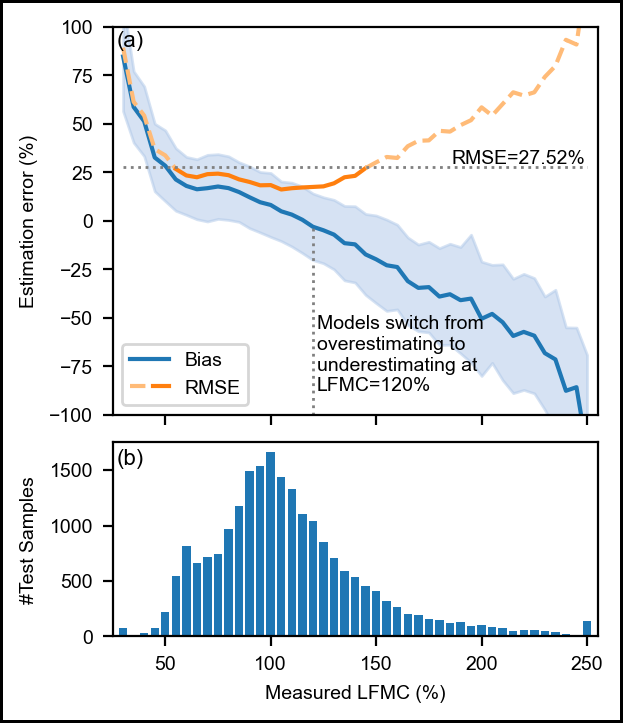

In [119]:
plt.rcParams.update({'font.sans-serif': 'Arial'})
fig, (ax1, ax2) = plt.subplots(2, 1, constrained_layout=True, figsize=(3, 3.5), dpi=200, sharex=True,
                               linewidth=2, edgecolor="black", gridspec_kw={'height_ratios': [2, 1]})

lower = 55
upper = 145
ax1 = plot_by_range(df1, ax1, [30, 250], xfocus=[lower, upper], yfocus=MODEL_RMSE, width=BIN_SIZE)
ax1.text(27.0, 98.0, '(a)', va='top', fontsize=TITLE_SIZE)
#ax1.set_box_aspect(1)

ax2 = samples_by_range(df3, ax2, 30, 250, width=BIN_SIZE, clip=True, xlabel_start=50, xlabel_freq=50)
ax2.text(27, 1600.0, '(b)', va='center', fontsize=TITLE_SIZE)
ax2.get_xlim()

fig.savefig(os.path.join(common.FIGURES_DIR, 'LFMC range.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.1, dpi=600)

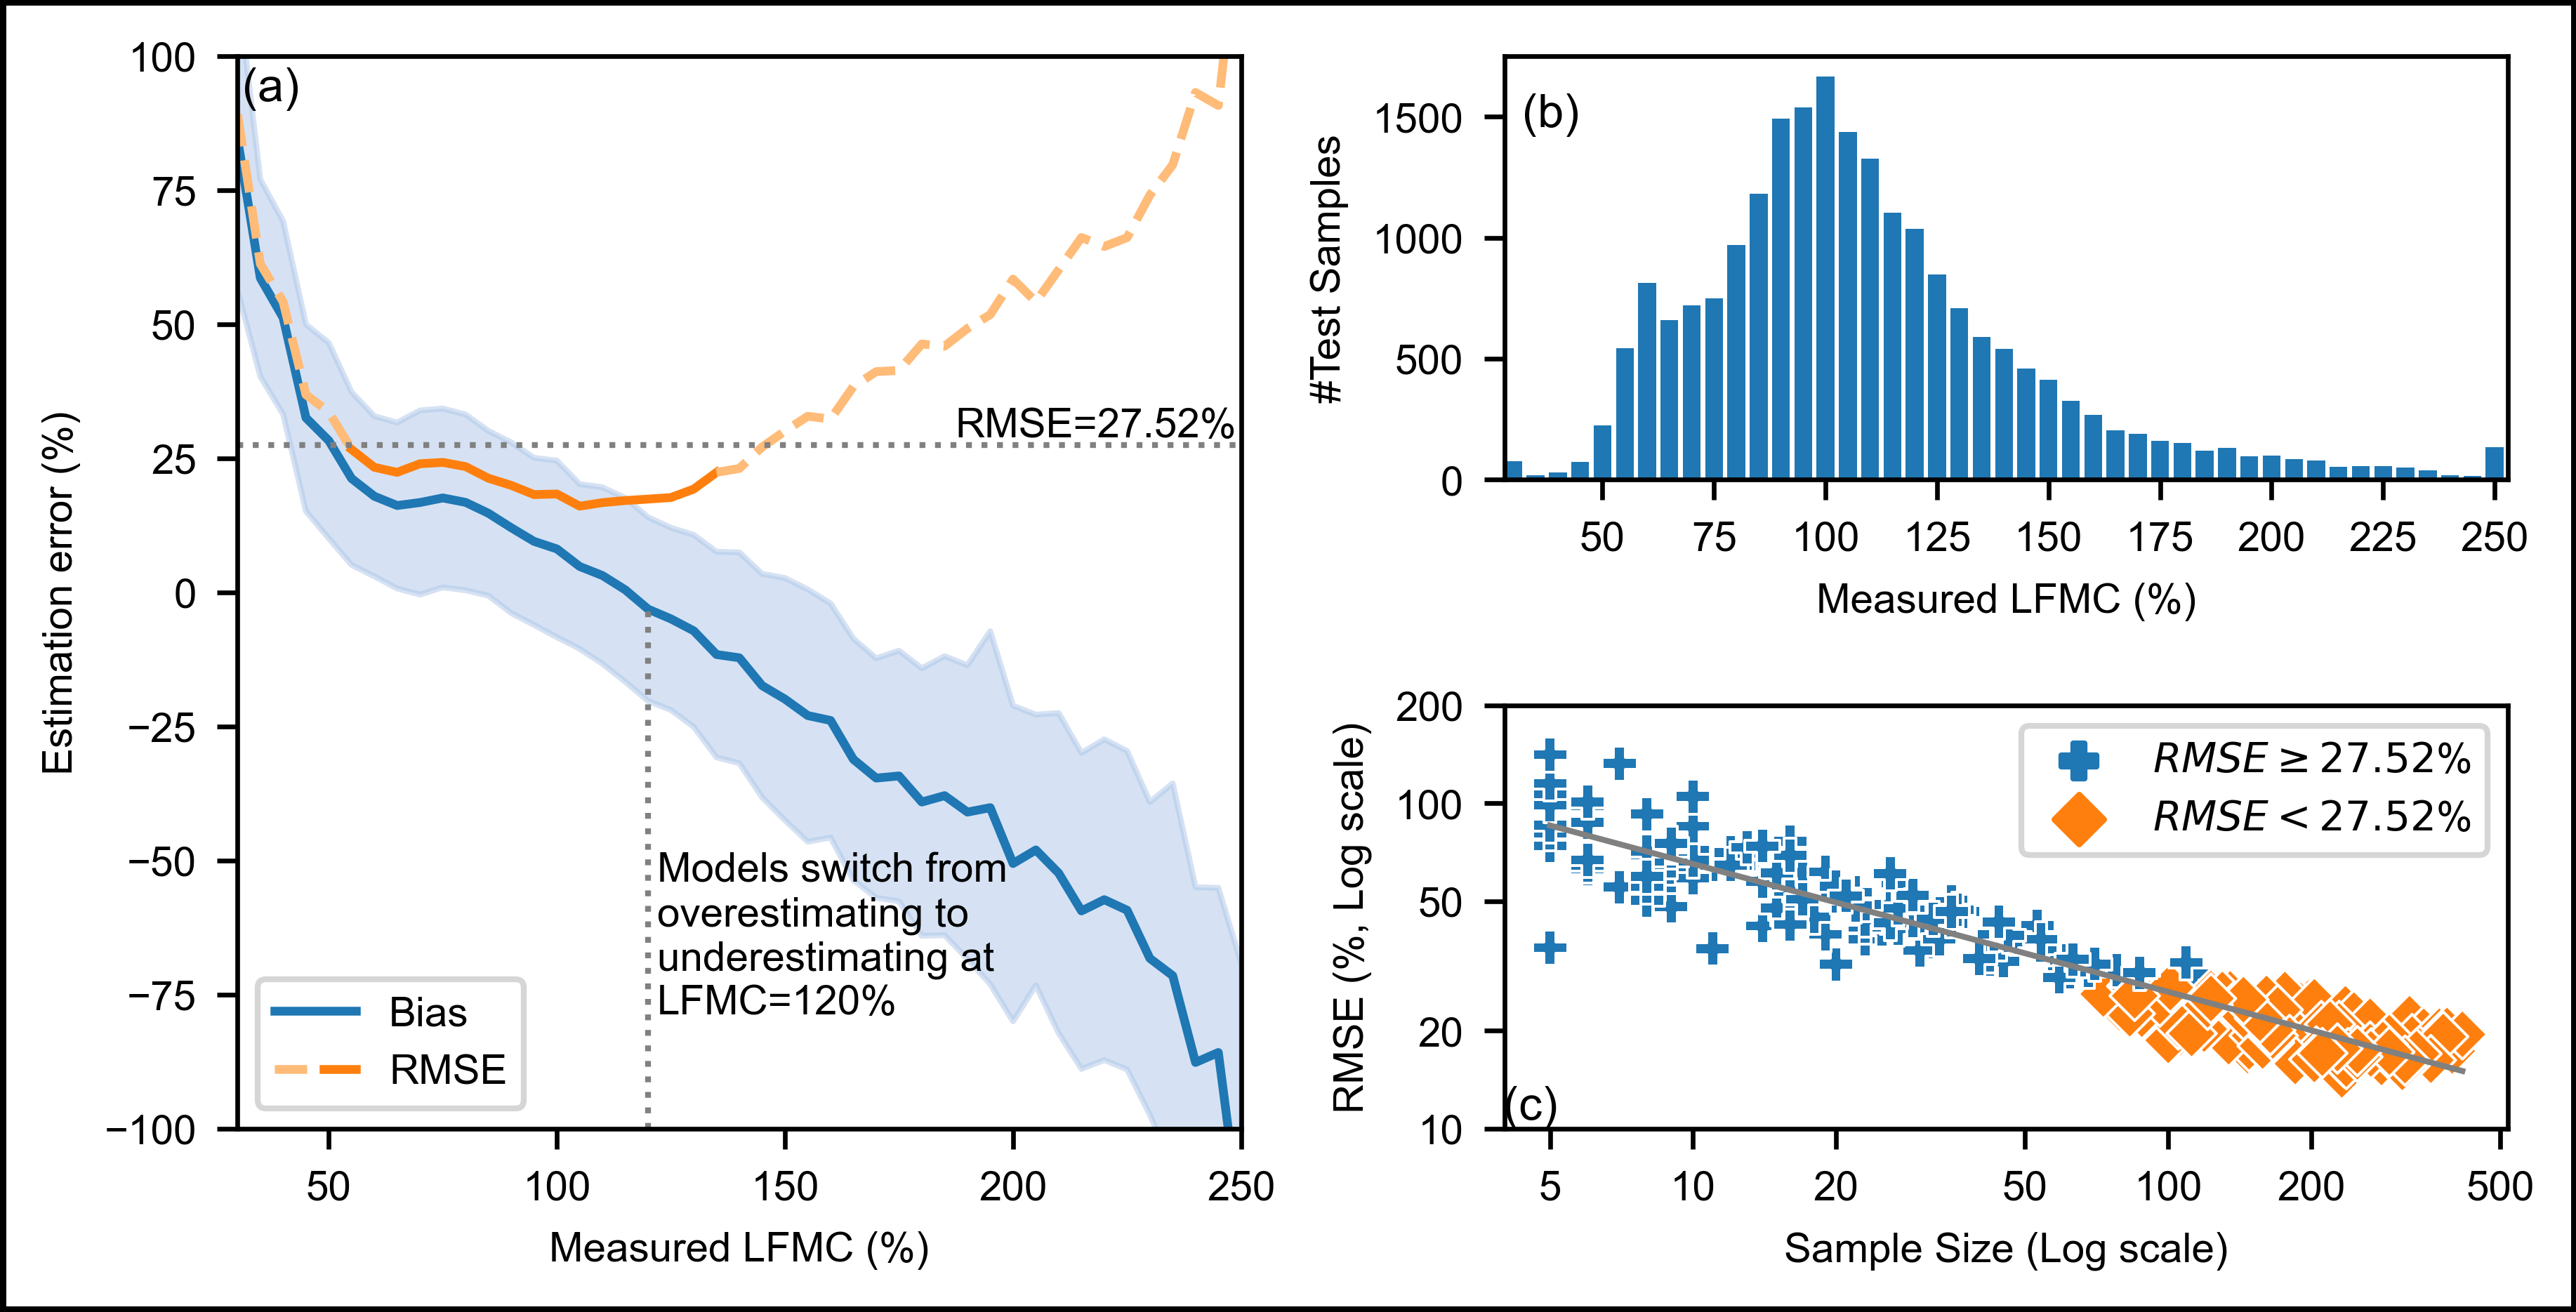

In [17]:
plt.rcParams.update({'font.sans-serif': 'Arial'})
fig = plt.figure(constrained_layout=True, figsize=(6, 3), dpi=600, linewidth=2, edgecolor="black")
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[:, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1])

lower = 55
upper = 135
ax1 = plot_by_range(df1, ax1, [30, 250], xfocus=[lower, upper], yfocus=MODEL_RMSE, width=BIN_SIZE)
ax1.text(31.0, 98.0, '(a)', va='top', fontsize=TITLE_SIZE)

ax2 = samples_by_range(df3, ax2, 30, 250, width=BIN_SIZE, clip=True, xlabel_start=4, xlabel_freq=5)
ax2.text(0.4, 1600.0, '(b)', va='top', fontsize=TITLE_SIZE)

ax3 = gen_scatterplot(x=rmse_df['Count'], y=rmse_df['RMSE'], ax=ax3, xlabels=xlabels, ylabels=ylabels, threshold=MODEL_RMSE)
ax3.text(0.6, 1.0, '(c)', va='bottom', fontsize=TITLE_SIZE)

#fig.tight_layout(pad=1)
#fig.savefig(os.path.join(common.FIGURES_DIR, 'LFMC range.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.1, dpi=600)